In [31]:
import numpy as onp
import jax.numpy as np
from jax import random, grad, vmap, jit

from jax.experimental.ode import odeint
from jax import config

import scipy.io as io

In [32]:
def RBF(x1, x2, params):
    output_scale, lengthscales = params
    diffs = np.expand_dims(x1 / lengthscales, 1) - \
            np.expand_dims(x2 / lengthscales, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)

In [33]:
# Geneate training data corresponding to one input sample
def data_generate(key, m=100, P=1, length_scale=0.2):
    # Sample GP prior at a fine grid
    N = 512
    gp_params = (1.0, length_scale)
    jitter = 1e-10
    X = np.linspace(0, 1, N)[:,None]
    K = RBF(X, X, gp_params)
    L = np.linalg.cholesky(K + jitter*np.eye(N))
    gp_sample = np.dot(L, random.normal(key, (N,)))

    # Create a callable interpolation function  
    u_fn = lambda x, t: np.interp(t, X.flatten(), gp_sample)

    # Input sensor locations and measurements
    x = np.linspace(0, 1, m)
    u = vmap(u_fn, in_axes=(None,0))(0.0, x)

    # Output sensor locations and measurements
    y = np.linspace(0, 1, P)
    
    s = odeint(u_fn, 0.0, y)

   

    return u, y, s


In [34]:
# Training Data
N_train = 10000 #Number of functions
m = 100 # number of input sensors
P_train = 20   # number of output sensors
key_train = random.PRNGKey(0) 

In [35]:
config.update("jax_enable_x64", True) # Enable double precision
keys = random.split(key_train, N_train) # Obtain 10000 random numbers

In [36]:
gen_fn = jit(lambda key: data_generate(key, m, P_train)) #lets call our function
u_train, y_train, s_train = vmap(gen_fn)(keys)

In [37]:
u_train = np.float32(u_train.reshape(N_train ,-1))
y_train = np.float32(y_train.reshape(N_train ,-1))
s_train = np.float32(s_train.reshape(N_train ,-1))


In [38]:
# Training Data
N_test = 100000 #Number of functions
m = 100 # number of input sensors
P_test = 20   # number of output sensors
key_test = random.PRNGKey(123456) 

In [39]:
config.update("jax_enable_x64", True) # Enable double precision
keys = random.split(key_test, N_test) # Obtain 10000 random numbers

In [40]:
gen_fn = jit(lambda key: data_generate(key, m, P_test)) #lets call our function
u_test, y_test, s_test = vmap(gen_fn)(keys)

In [41]:
u_test = np.float32(u_test.reshape(N_test ,-1))
y_test = np.float32(y_test.reshape(N_test, -1))
s_test = np.float32(s_test.reshape(N_test, -1))


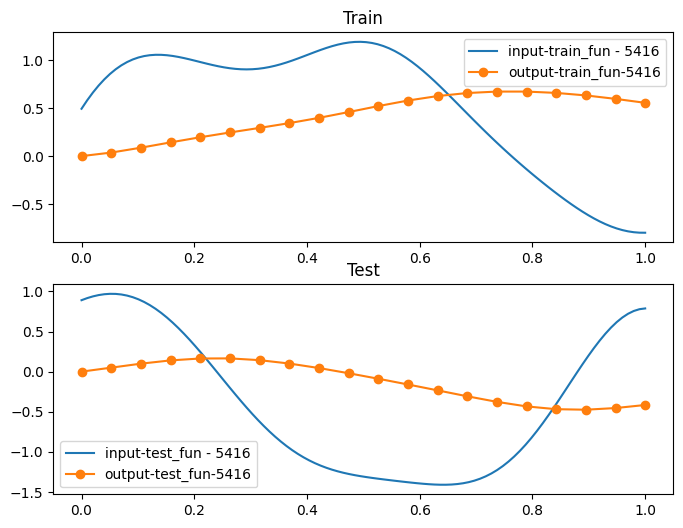

In [42]:
x = np.linspace(0, 1, m)
fun_num = onp.random.randint(0, u_train.shape[0])
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(2, 1,figsize = (8, 6))

axes[0].plot(x, u_train[fun_num], label = f'input-train_fun - {fun_num}')
axes[0].plot(y_train[fun_num], s_train[fun_num], 'o-', label = f'output-train_fun-{fun_num}')
axes[0].set_title('Train')
axes[0].legend()

axes[1].plot(x, u_test[fun_num], label = f'input-test_fun - {fun_num}')
axes[1].plot(y_test[fun_num], s_test[fun_num], 'o-', label = f'output-test_fun-{fun_num}')
axes[1].set_title('Test')
axes[1].legend()
plt.show()

In [43]:
data = { "u_train": onp.array(u_train), 
        'y_train': onp.array(y_train), 
        's_train': onp.array(s_train), 
        'u_test': onp.array(u_test), 
        'y_test':  onp.array( y_test), 
        's_test':onp.array( s_test)
        }

In [44]:
io.savemat('Data/Train_Test.mat', data)